# Toronto Housing ML: Neighbourhood Clustering Baseline

This notebook starts the group project by building a first end-to-end neighbourhood clustering baseline using the repository datasets.

Project context source: `README.md` in this repository.


## Course-Guided Modeling Choices

Applied from lecture notes (`SOTA Unsupervised Learning`, `Feature Engineering`, `Dimensionality Reduction`):

- Standardize features before K-Means.
- Use both elbow (inertia) and silhouette score to choose a reasonable number of clusters.
- Use PCA for 2D cluster visualization and interpretation.


In [1]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import BallTree
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)
sns.set_theme(style='whitegrid', context='notebook')

DATA_DIR = Path('../data')
OUTPUT_DIR = Path('../outputs')
EARTH_RADIUS_KM = 6371.0

In [2]:
crime_raw = pd.read_csv(DATA_DIR / 'MCI_2014_to_2019.csv')
rent_raw = pd.read_csv(DATA_DIR / 'Toronto_apartment_rentals_2018.csv')
rest_raw = pd.read_csv(DATA_DIR / 'trt_rest.csv')
subway_raw = pd.read_csv(DATA_DIR / 'toronto_subway_stations.csv')

print('Crime:', crime_raw.shape)
print('Rentals:', rent_raw.shape)
print('Restaurants:', rest_raw.shape)
print('Subway stations:', subway_raw.shape)

Crime: (206435, 29)
Rentals: (1124, 7)
Restaurants: (15821, 9)
Subway stations: (69, 3)


In [3]:
def split_neighbourhood_label(text: str):
    """Split labels like 'University (79)' into name + hood_id."""
    if pd.isna(text):
        return pd.Series([np.nan, np.nan])
    match = re.match(r'^(.*)\s\((\d+)\)$', str(text).strip())
    if match:
        return pd.Series([match.group(1).strip(), int(match.group(2))])
    return pd.Series([str(text).strip(), np.nan])


def parse_currency(value):
    if pd.isna(value):
        return np.nan
    cleaned = str(value).replace('$', '').replace(',', '').strip()
    try:
        return float(cleaned)
    except ValueError:
        return np.nan


def parse_restaurant_price(value):
    if pd.isna(value):
        return np.nan
    text = str(value).strip()
    nums = [int(n) for n in re.findall(r'\d+', text)]

    if len(nums) >= 2:
        return float(nums[0] + nums[1]) / 2.0
    if len(nums) == 1:
        return float(nums[0])

    dollar_count = text.count('$')
    if dollar_count:
        # Fallback mapping for '$', '$$', '$$$', '$$$$'
        return {1: 15.0, 2: 35.0, 3: 60.0, 4: 90.0}.get(dollar_count, np.nan)

    return np.nan


def nearest_neighbourhood_map(df, lat_col, lon_col, neighbourhood_centroids):
    """Map each point to the nearest neighbourhood centroid using haversine distance."""
    mapped = pd.DataFrame(index=df.index, columns=['hood_id', 'neighbourhood_name', 'distance_to_neighbourhood_km'])

    valid_idx = df[[lat_col, lon_col]].dropna().index
    if len(valid_idx) == 0:
        return pd.concat([df, mapped], axis=1)

    points = df.loc[valid_idx, [lat_col, lon_col]].to_numpy(dtype=float)
    centroids = neighbourhood_centroids[['centroid_lat', 'centroid_lon']].to_numpy(dtype=float)

    tree = BallTree(np.radians(centroids), metric='haversine')
    dist, ind = tree.query(np.radians(points), k=1)

    nearest = neighbourhood_centroids.iloc[ind.flatten()][['hood_id', 'neighbourhood_name']].reset_index(drop=True)

    mapped.loc[valid_idx, 'hood_id'] = nearest['hood_id'].values
    mapped.loc[valid_idx, 'neighbourhood_name'] = nearest['neighbourhood_name'].values
    mapped.loc[valid_idx, 'distance_to_neighbourhood_km'] = dist.flatten() * EARTH_RADIUS_KM

    mapped['hood_id'] = pd.to_numeric(mapped['hood_id'], errors='coerce').astype('Int64')
    mapped['distance_to_neighbourhood_km'] = pd.to_numeric(mapped['distance_to_neighbourhood_km'], errors='coerce')

    return pd.concat([df, mapped], axis=1)


def zscore(series):
    std = series.std(ddof=0)
    if std == 0 or pd.isna(std):
        return pd.Series(np.zeros(len(series)), index=series.index)
    return (series - series.mean()) / std

In [4]:
crime = crime_raw.copy()
crime[['neighbourhood_name', 'hood_id']] = crime['Neighbourhood'].apply(split_neighbourhood_label)
crime['hood_id'] = pd.to_numeric(crime['hood_id'], errors='coerce').astype('Int64')
crime['Lat'] = pd.to_numeric(crime['Lat'], errors='coerce')
crime['Long'] = pd.to_numeric(crime['Long'], errors='coerce')
crime['MCI'] = crime['MCI'].astype(str).str.strip()

crime = crime.dropna(subset=['hood_id', 'neighbourhood_name', 'Lat', 'Long'])
crime['is_violent'] = crime['MCI'].str.lower().isin({'assault', 'robbery', 'homicide'})

crime_agg = (
    crime
    .groupby(['hood_id', 'neighbourhood_name'], as_index=False)
    .agg(
        crime_incidents=('MCI', 'size'),
        violent_incidents=('is_violent', 'sum'),
        unique_mci_categories=('MCI', 'nunique'),
        centroid_lat=('Lat', 'mean'),
        centroid_lon=('Long', 'mean')
    )
)
crime_agg['violent_crime_ratio'] = crime_agg['violent_incidents'] / crime_agg['crime_incidents']

crime_agg.sort_values('crime_incidents', ascending=False).head()

,hood_id,neighbourhood_name,crime_incidents,violent_incidents,unique_mci_categories,centroid_lat,centroid_lon,violent_crime_ratio
76,77,Waterfront Communities-The Island,7747,5604,5,43.645157,-79.387852,0.723377
75,76,Bay Street Corridor,6817,5354,5,43.657107,-79.383572,0.785389
74,75,Church-Yonge Corridor,6232,4671,5,43.659558,-79.379599,0.749519
0,1,West Humber-Clairville,5702,2362,5,43.721487,-79.597169,0.414241
72,73,Moss Park,4786,3601,5,43.657104,-79.369559,0.752403


In [5]:
rent = rent_raw.copy()
rent['Price_num'] = rent['Price'].apply(parse_currency)
rent['Lat'] = pd.to_numeric(rent['Lat'], errors='coerce')
rent['Long'] = pd.to_numeric(rent['Long'], errors='coerce')

# Keep Toronto listings only for cleaner geographic matching.
rent = rent[rent['Address'].astype(str).str.contains('Toronto', case=False, na=False)].copy()
rent = rent.dropna(subset=['Lat', 'Long', 'Price_num'])

rent_mapped = nearest_neighbourhood_map(rent, 'Lat', 'Long', crime_agg[['hood_id', 'neighbourhood_name', 'centroid_lat', 'centroid_lon']])

rent_agg = (
    rent_mapped
    .dropna(subset=['hood_id'])
    .groupby(['hood_id', 'neighbourhood_name'], as_index=False)
    .agg(
        rent_listings=('Price_num', 'size'),
        median_rent=('Price_num', 'median'),
        mean_rent=('Price_num', 'mean')
    )
)

rent_agg.sort_values('rent_listings', ascending=False).head()

,hood_id,neighbourhood_name,rent_listings,median_rent,mean_rent
26,77,Waterfront Communities-The Island,283,2400.0,2564.660777
24,75,Church-Yonge Corridor,83,2200.0,2297.566265
25,76,Bay Street Corridor,66,2100.0,2146.924242
30,82,Niagara,64,2300.0,2383.421875
23,74,North St.James Town,57,2000.0,30212.929825


In [6]:
rest = rest_raw.copy()
rest['Restaurant Latitude'] = pd.to_numeric(rest['Restaurant Latitude'], errors='coerce')
rest['Restaurant Longitude'] = pd.to_numeric(rest['Restaurant Longitude'], errors='coerce')
rest['restaurant_price_mid'] = rest['Restaurant Price Range'].apply(parse_restaurant_price)
rest = rest.dropna(subset=['Restaurant Latitude', 'Restaurant Longitude'])

rest_mapped = nearest_neighbourhood_map(
    rest,
    'Restaurant Latitude',
    'Restaurant Longitude',
    crime_agg[['hood_id', 'neighbourhood_name', 'centroid_lat', 'centroid_lon']]
)

rest_agg = (
    rest_mapped
    .dropna(subset=['hood_id'])
    .groupby(['hood_id', 'neighbourhood_name'], as_index=False)
    .agg(
        restaurant_count=('Restaurant Name', 'size'),
        avg_restaurant_price=('restaurant_price_mid', 'mean')
    )
)

rest_agg.sort_values('restaurant_count', ascending=False).head()

,hood_id,neighbourhood_name,restaurant_count,avg_restaurant_price
76,77,Waterfront Communities-The Island,1184,21.348677
77,78,Kensington-Chinatown,612,17.376437
75,76,Bay Street Corridor,609,19.228381
94,95,Annex,557,23.478571
72,73,Moss Park,386,20.735577


In [7]:
subway = subway_raw.copy()
subway['latitude'] = pd.to_numeric(subway['latitude'], errors='coerce')
subway['longitude'] = pd.to_numeric(subway['longitude'], errors='coerce')
subway = subway.dropna(subset=['latitude', 'longitude'])

subway_points = subway[['latitude', 'longitude']].to_numpy(dtype=float)
subway_tree = BallTree(np.radians(subway_points), metric='haversine')

neighbourhood_points = crime_agg[['centroid_lat', 'centroid_lon']].to_numpy(dtype=float)
subway_dist, _ = subway_tree.query(np.radians(neighbourhood_points), k=1)

subway_features = crime_agg[['hood_id', 'neighbourhood_name']].copy()
subway_features['nearest_subway_km'] = subway_dist.flatten() * EARTH_RADIUS_KM

subway_features.head()

,hood_id,neighbourhood_name,nearest_subway_km
0,1,West Humber-Clairville,9.367244
1,2,Mount Olive-Silverstone-Jamestown,7.200916
2,3,Thistletown-Beaumond Heights,6.296100
3,4,Rexdale-Kipling,7.510936
4,5,Elms-Old Rexdale,6.728028


In [8]:
features = (
    crime_agg
    .merge(rent_agg, on=['hood_id', 'neighbourhood_name'], how='left')
    .merge(rest_agg, on=['hood_id', 'neighbourhood_name'], how='left')
    .merge(subway_features, on=['hood_id', 'neighbourhood_name'], how='left')
)

# Missingness flags inspired by feature-engineering lecture guidance.
features['rent_data_missing'] = features['median_rent'].isna().astype(int)
features['restaurant_price_missing'] = features['avg_restaurant_price'].isna().astype(int)

for col in ['rent_listings', 'restaurant_count']:
    features[col] = features[col].fillna(0)

for col in ['median_rent', 'mean_rent', 'avg_restaurant_price', 'nearest_subway_km']:
    features[col] = features[col].fillna(features[col].median())

# Log-transform skewed count features for stability.
features['log_crime_incidents'] = np.log1p(features['crime_incidents'])
features['log_rent_listings'] = np.log1p(features['rent_listings'])
features['log_restaurant_count'] = np.log1p(features['restaurant_count'])

model_features = [
    'log_crime_incidents',
    'violent_crime_ratio',
    'unique_mci_categories',
    'median_rent',
    'log_rent_listings',
    'log_restaurant_count',
    'avg_restaurant_price',
    'nearest_subway_km',
    'rent_data_missing',
    'restaurant_price_missing'
]

print('Neighbourhood rows:', len(features))
features[model_features].describe().T

Neighbourhood rows: 140


,count,mean,std,min,25%,50%,75%,max
log_crime_incidents,140.0,7.060957,0.652255,5.869297,6.571918,7.029495,7.459612,8.955190
violent_crime_ratio,140.0,0.614371,0.119927,0.271132,0.550103,0.630376,0.699569,0.831470
unique_mci_categories,140.0,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000
median_rent,140.0,2004.642857,1536.862333,65.000000,1897.000000,1897.000000,1897.000000,19425.000000
log_rent_listings,140.0,0.610846,1.122267,0.000000,0.000000,0.000000,0.693147,5.648974
log_restaurant_count,140.0,4.193331,1.150470,0.000000,3.518897,4.382027,4.936266,7.077498
avg_restaurant_price,140.0,18.802011,4.489510,10.000000,16.300000,18.580760,20.106109,45.500000
nearest_subway_km,140.0,2.548648,2.372525,0.026848,0.790793,1.632637,3.565873,10.713556
rent_data_missing,140.0,0.642857,0.480878,0.000000,0.000000,1.000000,1.000000,1.000000
restaurant_price_missing,140.0,0.014286,0.119092,0.000000,0.000000,0.000000,0.000000,1.000000


In [9]:
scaler = StandardScaler()
X = features[model_features].copy()
X_scaled = scaler.fit_transform(X)

k_values = list(range(2, min(11, len(features))))
results = []

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = model.fit_predict(X_scaled)
    results.append({
        'k': k,
        'inertia': model.inertia_,
        'silhouette': silhouette_score(X_scaled, labels)
    })

selection_df = pd.DataFrame(results)
best_k = int(selection_df.sort_values('silhouette', ascending=False).iloc[0]['k'])
print(f'Best k by silhouette: {best_k}')
selection_df

Best k by silhouette: 2


,k,inertia,silhouette
0,2,1006.963661,0.255785
1,3,902.889432,0.213365
2,4,834.543766,0.191341
3,5,682.243734,0.208129
4,6,652.241929,0.135878
5,7,561.662185,0.169905
6,8,454.304089,0.177510
7,9,408.419162,0.185857
8,10,369.468575,0.161540


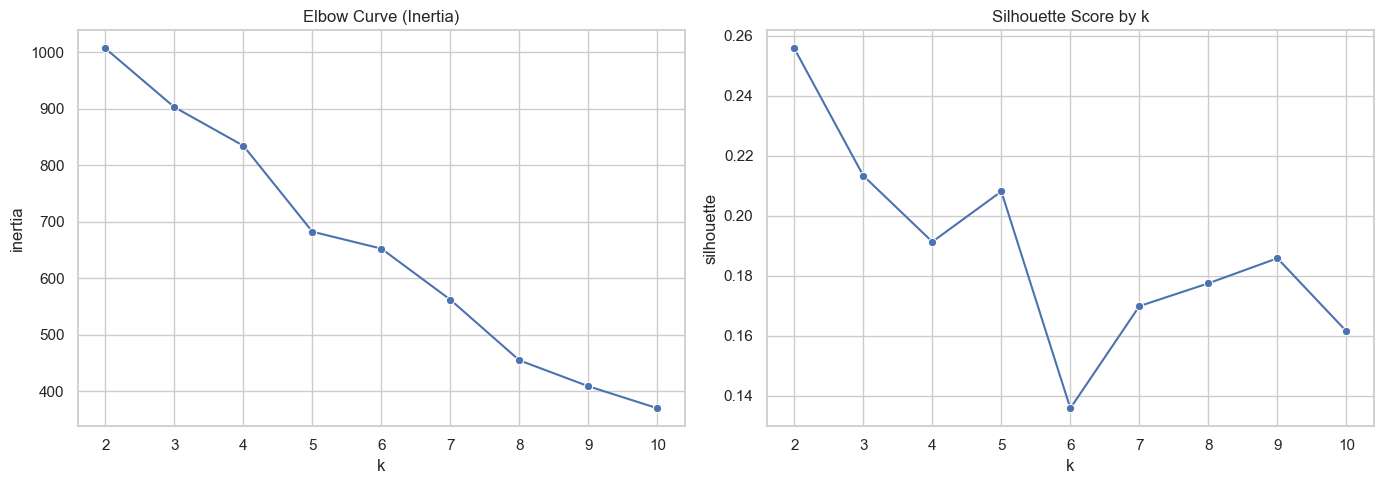

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.lineplot(data=selection_df, x='k', y='inertia', marker='o', ax=axes[0])
axes[0].set_title('Elbow Curve (Inertia)')

sns.lineplot(data=selection_df, x='k', y='silhouette', marker='o', ax=axes[1])
axes[1].set_title('Silhouette Score by k')

plt.tight_layout()
plt.show()

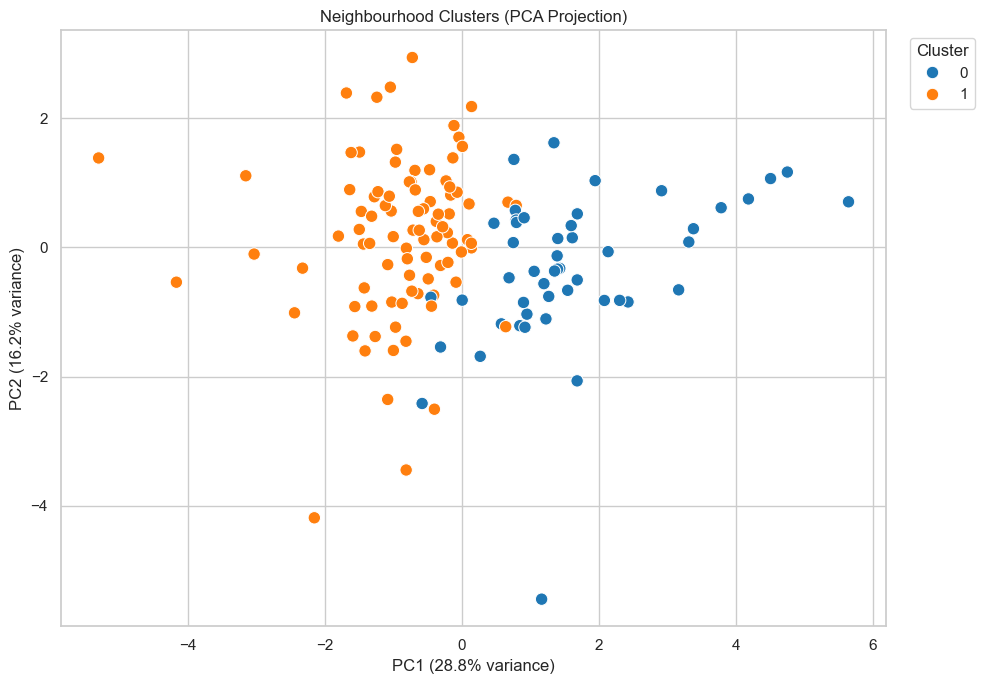

In [11]:
final_model = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
features['cluster'] = final_model.fit_predict(X_scaled)

pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(X_scaled)
features['pc1'] = pcs[:, 0]
features['pc2'] = pcs[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=features, x='pc1', y='pc2', hue='cluster', palette='tab10', s=80)
plt.title('Neighbourhood Clusters (PCA Projection)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [12]:
cluster_profile = (
    features
    .groupby('cluster', as_index=False)
    .agg(
        neighbourhoods=('hood_id', 'size'),
        crime_incidents=('crime_incidents', 'mean'),
        violent_crime_ratio=('violent_crime_ratio', 'mean'),
        median_rent=('median_rent', 'mean'),
        restaurant_count=('restaurant_count', 'mean'),
        avg_restaurant_price=('avg_restaurant_price', 'mean'),
        nearest_subway_km=('nearest_subway_km', 'mean')
    )
    .sort_values('cluster')
)

cluster_profile

,cluster,neighbourhoods,crime_incidents,violent_crime_ratio,median_rent,restaurant_count,avg_restaurant_price,nearest_subway_km
0,0,49,1729.285714,0.648530,2206.530612,171.020408,19.415566,1.380675
1,1,91,1337.362637,0.595978,1895.934066,81.241758,18.471635,3.177556


## Emerging Neighbourhood Candidates (Initial Heuristic)

For a first pass, we define an `emerging_score` to prioritize neighbourhoods that are:

- more affordable (lower rent),
- safer (lower crime),
- more accessible/active (more restaurants + closer to subway).

This is a baseline ranking, not a final project conclusion.


In [13]:
features['affordability_score'] = -zscore(features['median_rent'])
features['safety_score'] = -zscore(features['crime_incidents'])
features['amenity_score'] = zscore(features['restaurant_count']) - zscore(features['nearest_subway_km'])

features['emerging_score'] = (
    0.40 * features['affordability_score']
    + 0.30 * features['safety_score']
    + 0.30 * features['amenity_score']
)

emerging_candidates = features.sort_values('emerging_score', ascending=False).copy()
emerging_candidates[['hood_id', 'neighbourhood_name', 'cluster', 'emerging_score', 'median_rent', 'crime_incidents', 'restaurant_count', 'nearest_subway_km']].head(15)

,hood_id,neighbourhood_name,cluster,emerging_score,median_rent,crime_incidents,restaurant_count,nearest_subway_km
79,80,Palmerston-Little Italy,0,1.166317,65.0,1053,249.0,0.451749
76,77,Waterfront Communities-The Island,0,0.930062,2400.0,7747,1184.0,0.378587
94,95,Annex,0,0.889664,1967.5,2917,557.0,0.316394
14,15,Kingsway South,1,0.877618,1897.0,496,274.0,0.445372
78,79,University,0,0.869074,1000.0,1455,282.0,0.652725
77,78,Kensington-Chinatown,0,0.710572,2025.0,3823,612.0,0.794971
80,81,Trinity-Bellwoods,1,0.691595,1897.0,1572,374.0,1.527202
99,100,Yonge-Eglinton,0,0.679068,1300.0,823,130.0,0.189997
88,89,Runnymede-Bloor West Village,1,0.651649,1897.0,573,210.0,1.002178
68,69,Blake-Jones,0,0.649541,1300.0,679,114.0,0.430061


In [14]:
OUTPUT_DIR.mkdir(exist_ok=True)

features.sort_values(['cluster', 'neighbourhood_name']).to_csv(OUTPUT_DIR / 'neighbourhood_clusters.csv', index=False)
features.sort_values('hood_id').to_csv(OUTPUT_DIR / 'neighbourhood_features.csv', index=False)
cluster_profile.to_csv(OUTPUT_DIR / 'cluster_profiles.csv', index=False)
emerging_candidates.head(25).to_csv(OUTPUT_DIR / 'emerging_neighbourhood_candidates.csv', index=False)

print('Saved files:')
for p in sorted(OUTPUT_DIR.glob('*.csv')):
    print(' -', p)

Saved files:
 - ../outputs/cluster_profiles.csv
 - ../outputs/emerging_neighbourhood_candidates.csv
 - ../outputs/neighbourhood_clusters.csv
 - ../outputs/neighbourhood_features.csv


## Next Team Tasks

1. Validate the neighbourhood mapping approach (nearest-centroid) against a boundary shapefile if available.
2. Compare K-Means with DBSCAN/HDBSCAN from the lecture content.
3. Add robustness checks: alternate feature sets, alternate years, and sensitivity analysis for `emerging_score` weights.
